# ***Predicting Video Popularity: Use viewCount, likeCount, or commentCount as the target column.***

# Classifying Structured Data using Keras Preprocessing Layers

Understanding the Data Columns

- title: This is text data and can be treated as a categorical feature or used in natural language processing (NLP) models to extract meaningful features.

- publishedAt_timestamp: This timestamp can be used to extract features like hour, day of the week, month, etc., which might correlate with viewer behavior.

- viewCount, likeCount, commentCount: These are numerical features that directly reflect user engagement and can be critical indicators of a video's success.

- tagCount: This numerical feature represents how many tags are associated with the video, which might correlate with its discoverability.

- duration_seconds: A numerical feature indicating the length of the video, which can affect viewer engagement and completion rates.

- caption_False, caption_True: These binary features indicate whether captions are available, which can be important for accessibility and engagement.

- definition_hd, definition_sd: Binary features that indicate the video quality, potentially impacting user engagement.

- publishDayName: This categorical feature can be used to see if videos perform differently depending on the day of the week they are published.


In [1]:
!pip install isodate==0.6.1
!sudo apt install graphviz -y
!pip install tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf
import isodate
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.layers import CategoryEncoding, StringLookup, IntegerLookup, Normalization

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
hips = pd.read_csv('/content/drive/MyDrive/snakeHipsAnal/snakeHips.csv')

In [4]:
hips.isnull().sum()
hips.dropna()
hips['durationSecs'] = hips['duration'].apply(lambda x: isodate.parse_duration(x))
hips['duration_seconds'] = hips['durationSecs'].dt.total_seconds()

In [5]:
hips.isin([0, np.nan]).sum()

,0
video_id,0
channelTitle,0
title,0
description,8
tags,5
publishedAt,0
viewCount,1
likeCount,0
favouriteCount,128
commentCount,9


In [6]:
hips['publishedAt'] = pd.to_datetime(hips['publishedAt'])
hips['publishedAt_timestamp'] = hips['publishedAt'].apply(lambda x: x.timestamp())
hips = hips.replace('\$', '', regex=True)
hips['publishDayName'] = hips['pushblishDayName']

In [7]:
columns_to_keep = [
    'title', 'publishedAt_timestamp', 'viewCount', 'likeCount',
    'commentCount', 'tagCount', 'duration_seconds', 'publishDayName', 'definition', 'caption'
]

# Keep only the relevant columns
hips = hips[columns_to_keep]

In [8]:
hips

,title,publishedAt_timestamp,viewCount,likeCount,commentCount,tagCount,duration_seconds,publishDayName,definition,caption
0,Snakehips & EARTHGANG (SNAKEGANG) - The Remedy...,1.721935e+09,4983.0,212.0,7.0,13,198.0,Thursday,hd,False
1,Snakehips & EARTHGANG (SNAKEGANG) - Bounce ft....,1.721669e+09,7341.0,339.0,9.0,13,222.0,Monday,hd,False
2,Snakehips & EARTHGANG (SNAKEGANG) - GLIMMER. (...,1.721405e+09,341304.0,2112.0,53.0,13,176.0,Friday,hd,False
3,Snakehips & EARTHGANG (SNAKEGANG) feat Sinéad ...,1.719133e+09,163764.0,3121.0,32.0,21,190.0,Sunday,hd,False
4,Snakehips - Bringing Me Home (feat. LAUREL) (O...,1.702472e+09,154845.0,321.0,7.0,13,210.0,Wednesday,hd,False
...,...,...,...,...,...,...,...,...,...,...
123,Banks - Warm Water (SNAKEHIPS Remix),1.403103e+09,15605.0,261.0,4.0,21,165.0,Wednesday,sd,False
124,The Weeknd - Wanderlust (SNAKEHIPS Remix),1.403091e+09,838720.0,8766.0,62.0,21,221.0,Wednesday,sd,False
125,SNAKEHIPS - Miss U Always,1.403023e+09,47582.0,593.0,11.0,18,156.0,Tuesday,sd,False
126,SNAKEHIPS - Make It,1.403005e+09,49497.0,462.0,10.0,18,222.0,Tuesday,sd,False


In [9]:
df = hips
df.head()

,title,publishedAt_timestamp,viewCount,likeCount,commentCount,tagCount,duration_seconds,publishDayName,definition,caption
0,Snakehips & EARTHGANG (SNAKEGANG) - The Remedy...,1.721935e+09,4983.0,212.0,7.0,13,198.0,Thursday,hd,False
1,Snakehips & EARTHGANG (SNAKEGANG) - Bounce ft....,1.721669e+09,7341.0,339.0,9.0,13,222.0,Monday,hd,False
2,Snakehips & EARTHGANG (SNAKEGANG) - GLIMMER. (...,1.721405e+09,341304.0,2112.0,53.0,13,176.0,Friday,hd,False
3,Snakehips & EARTHGANG (SNAKEGANG) feat Sinéad ...,1.719133e+09,163764.0,3121.0,32.0,21,190.0,Sunday,hd,False
4,Snakehips - Bringing Me Home (feat. LAUREL) (O...,1.702472e+09,154845.0,321.0,7.0,13,210.0,Wednesday,hd,False


In [10]:
# Define a composite score for popularity (e.g., a weighted sum of views, likes, and comments)
df['popularity_score'] = df['viewCount'] + df['likeCount'] * 10 + df['commentCount'] * 20

# Optionally, create a binary target column based on the composite score
# For example, videos with a popularity score above a certain threshold are considered popular
threshold = df['popularity_score'].median()
df['target'] = np.where(df['popularity_score'] > threshold, 1, 0)

# Drop unused columns
df = df.drop(columns=['title', 'publishedAt_timestamp', 'popularity_score', 'caption'], errors='ignore')

In [11]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

81 train examples
21 validation examples
26 test examples


In [12]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [13]:
batch_size = 5
# TODO
# call the necessary function with required parameters
train_ds = df_to_dataset(train, batch_size=batch_size)

In [14]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of viewCounts:', train_features['viewCount'])
print('A batch of targets:', label_batch )

Every feature: ['viewCount', 'likeCount', 'commentCount', 'tagCount', 'duration_seconds', 'publishDayName', 'definition']
A batch of viewCounts: tf.Tensor([   59719. 33263465.   163764.    90708.   424713.], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)


In [15]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = Normalization(axis=None)

# TODO
  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [16]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = StringLookup(max_tokens=max_tokens)
  else:
    index = IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [17]:
df.dtypes

,0
viewCount,float64
likeCount,float64
commentCount,float64
tagCount,int64
duration_seconds,float64
publishDayName,object
definition,object
target,int64


In [18]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [19]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['viewCount', 'likeCount', 'commentCount', 'tagCount']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [20]:
# Categorical features encoded as integers.
age_col = tf.keras.Input(shape=(1,), name='duration_seconds', dtype='float64')
encoding_layer = get_category_encoding_layer('duration_seconds', train_ds, dtype='float64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [21]:
# Categorical features encoded as string.
categorical_cols = ['definition', 'publishDayName']
for header in categorical_cols:
      categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
      encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string', max_tokens=5)
      encoded_categorical_col = encoding_layer(categorical_col)
      all_inputs.append(categorical_col)
      encoded_features.append(encoded_categorical_col)

In [22]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(encoded_features, output)
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

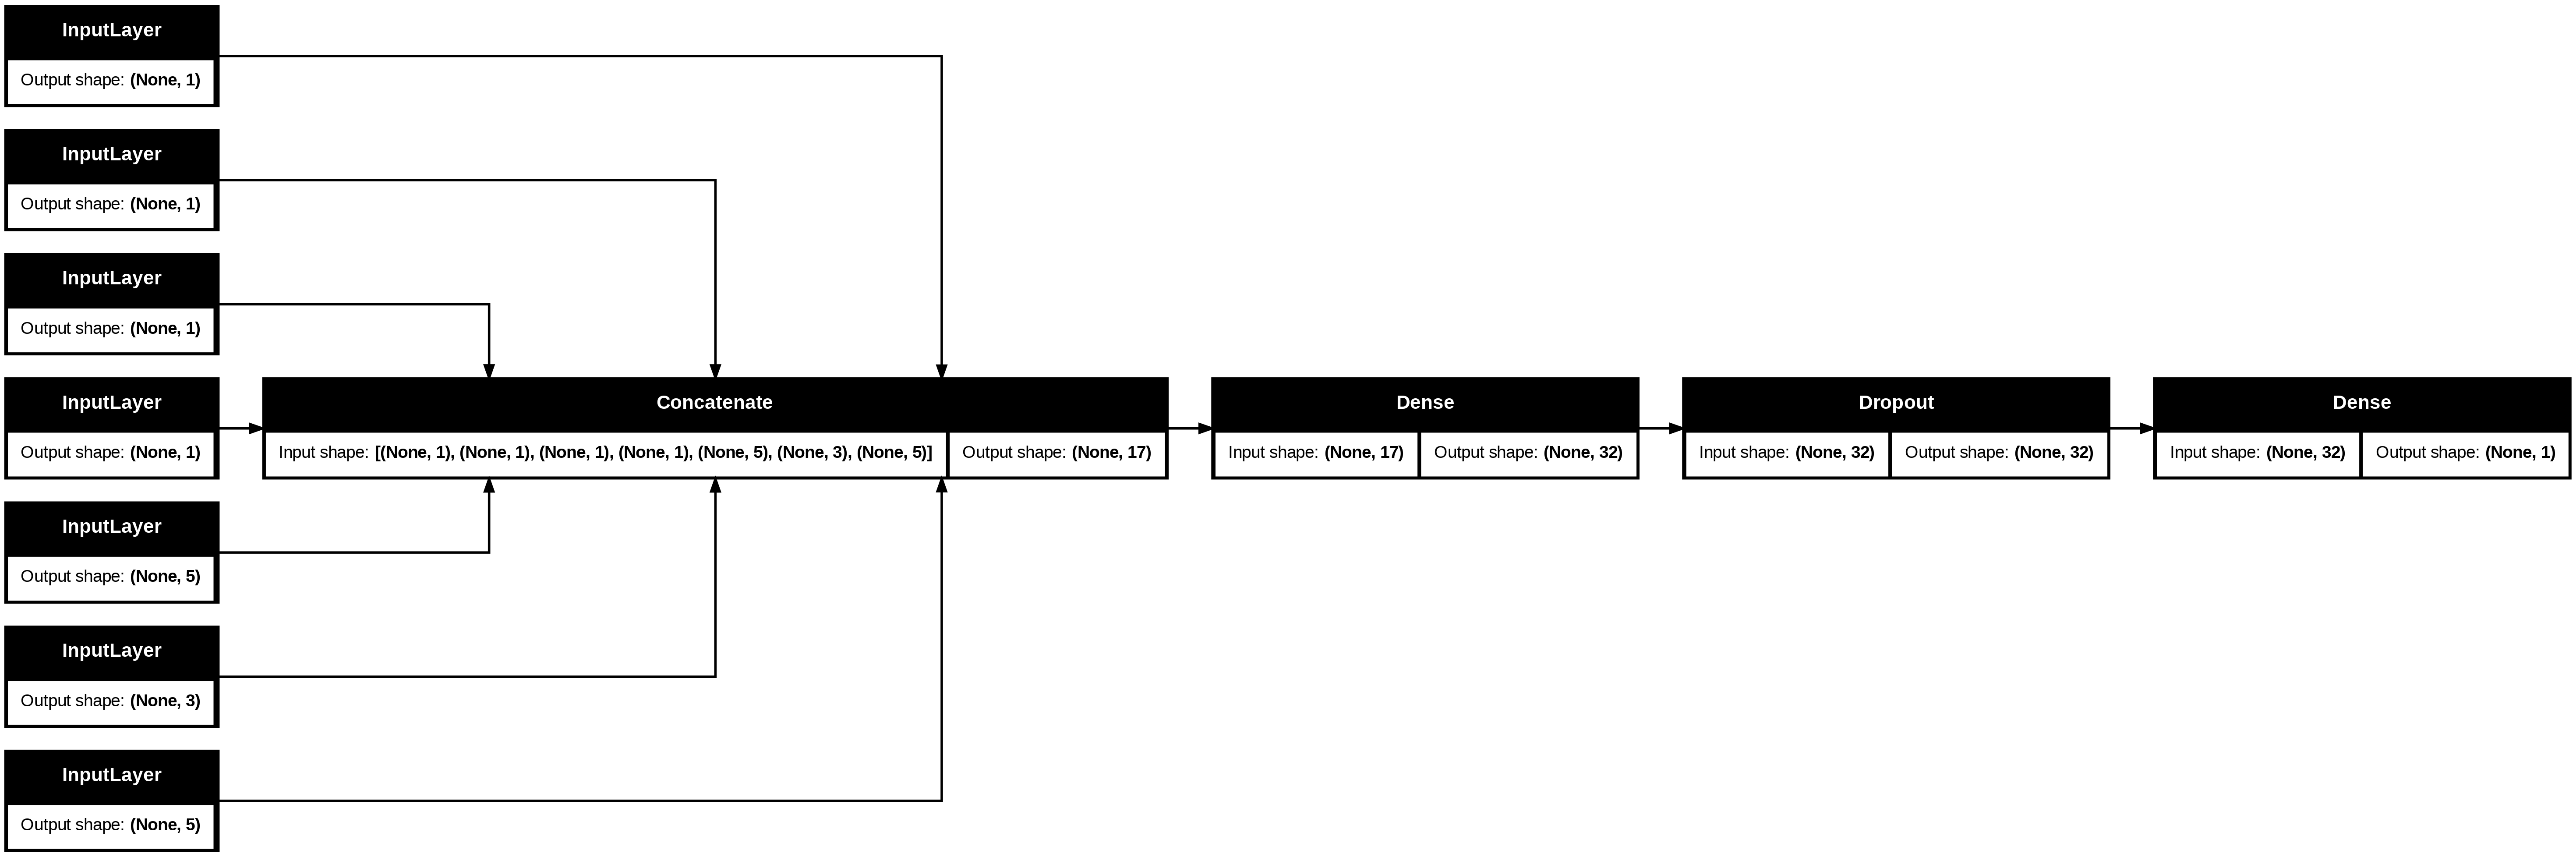

In [23]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [24]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


ValueError: Missing data for input "keras_tensorCLONE". You passed a data dictionary with keys ['viewCount', 'likeCount', 'commentCount', 'tagCount', 'duration_seconds', 'publishDayName', 'definition']. Expected the following keys: ['keras_tensorCLONE', 'keras_tensor_1CLONE', 'keras_tensor_2CLONE', 'keras_tensor_3CLONE', 'keras_tensor_5CLONE', 'keras_tensor_7CLONE', 'keras_tensor_9CLONE']